<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.06/LGBM_retweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# Installs latest version of TensorFlow 2.X 
# !pip install --upgrade tensorflow

In [94]:
# Import our dependencies
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import datetime
from datetime import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
import tensorflow as tf

In [95]:
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 3s (89.5 kB/s)
Reading package l

In [96]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [97]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://uaresources.s3.us-west-1.amazonaws.com/sentiment_joined_events_twitter_post_ml.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("sentiment_joined_events_twitter_post_ml.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|_c0|       username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|is_retweet|is_quote_status|extractedts|weekofyear|date_published|search_result| weight|        cleaned_text|            negative|             neutral|            positive|
+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|  0|      WashTimes|   1893.0| 417389.0|   335685.0|   2008-05-

# Exploring the taken data

In [123]:
# Convert DataFrame to Pandas
joined_data_df = text_df.toPandas()
print(joined_data_df.shape)
joined_data_df.head(5)

(713009, 22)


,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
0,0,WashTimes,1893.0,417389.0,335685.0,2008-05-05,2022-02-26,0.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,democrats urge biden to counter pain at pump w...,0.222473,0.747085,0.030443
1,1,jacarroll,64.0,254.0,110.0,2008-01-07,2022-02-26,0.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,now is the time to annex cuba just sayin,0.078324,0.799905,0.121771
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,just grasping at straws here but does anyone h...,0.147500,0.824443,0.028057
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
4,4,scholar_at_arms,975.0,75.0,1988.0,2008-09-26,2022-02-26,0.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,please take care,0.063437,0.643451,0.293113


In [124]:
# Change the dtypes of tweetcreatedts
joined_data_df["tweetcreatedts"] = pd.to_datetime(joined_data_df["tweetcreatedts"])
print (joined_data_df["tweetcreatedts"])

0        2022-02-26
1        2022-02-26
2        2022-02-26
3        2022-02-26
4        2022-02-26
            ...    
713004   2022-02-26
713005   2022-02-26
713006   2022-02-26
713007   2022-02-26
713008          NaT
Name: tweetcreatedts, Length: 713009, dtype: datetime64[ns]


In [125]:
# drop the row with NaT values in the tweetcreatedts column
joined_data_df = joined_data_df.dropna(axis=0, subset=['tweetcreatedts']) 
joined_data_df.shape

(713008, 22)

# Cleaning data

In [126]:
# Drop the not needed column
joined_data_df.drop("_c0", axis=1, inplace=True)
joined_data_df.drop("username", axis=1, inplace=True)
joined_data_df.drop("usercreatedts", axis=1, inplace=True)
joined_data_df.drop("language", axis=1, inplace=True)
#joined_data_df.drop("favorite_count", axis=1, inplace=True)
joined_data_df.drop("extractedts", axis=1, inplace=True)
joined_data_df.drop("weekofyear", axis=1, inplace=True)
joined_data_df.drop("neutral", axis=1, inplace=True)
joined_data_df.drop("positive", axis=1, inplace=True)
joined_data_df.drop("search_result", axis=1, inplace=True)
joined_data_df.drop("retweetcount", axis=1, inplace=True)
joined_data_df.drop("date_published", axis=1, inplace=True)

In [127]:
# convert text to text lenght and drop the text
joined_data_df['text_length']  = joined_data_df['cleaned_text'].str.len()
joined_data_df.drop("cleaned_text", axis=1, inplace=True)

In [128]:
# Change object type to boolean for columns 'is_retweet' and 'is_quote_status'
joined_data_df["is_retweet"] = joined_data_df['is_retweet'].astype(bool)
joined_data_df["is_quote_status"] = joined_data_df['is_quote_status'].astype(bool)
# Replace boolean columns
joined_data_df['is_retweet'] = joined_data_df['is_retweet'].astype(int)
joined_data_df['is_quote_status'] = joined_data_df['is_quote_status'].astype(int)
joined_data_df.head()

,following,followers,totaltweets,tweetcreatedts,hashtags,favorite_count,is_retweet,is_quote_status,weight,negative,text_length
0,1893.0,417389.0,335685.0,2022-02-26,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",0.0,0,0,0.000533,0.222473,77.0
1,64.0,254.0,110.0,2022-02-26,"[{'text': 'StandWithUkriane', 'indices': [58, ...",0.0,0,0,0.000533,0.078324,40.0
2,5766.0,5329.0,119448.0,2022-02-26,[],0.0,0,0,0.000533,0.147500,138.0
3,294.0,172.0,15270.0,2022-02-26,[],0.0,0,0,0.000533,0.883955,220.0
4,975.0,75.0,1988.0,2022-02-26,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",0.0,0,0,0.000533,0.063437,16.0


# Exploring the hashtags

In [129]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713008 entries, 0 to 713007
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   following        713008 non-null  float64       
 1   followers        713008 non-null  float64       
 2   totaltweets      713008 non-null  float64       
 3   tweetcreatedts   713008 non-null  datetime64[ns]
 4   hashtags         713008 non-null  object        
 5   favorite_count   713008 non-null  float64       
 6   is_retweet       713008 non-null  int64         
 7   is_quote_status  713008 non-null  int64         
 8   weight           710366 non-null  float64       
 9   negative         713008 non-null  float64       
 10  text_length      712997 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 65.3+ MB


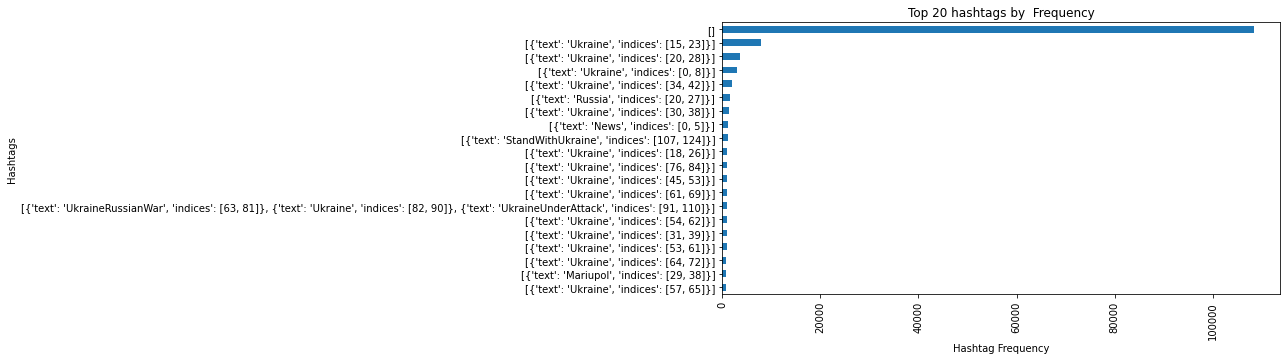

In [130]:
# Find the top 20 hashtags by frequency
plt.figure(figsize=(10,5))
joined_data_df["hashtags"].value_counts().sort_values(ascending=True)[-20:].plot.barh();
plt.title("Top 20 hashtags by  Frequency")
plt.xlabel("Hashtag Frequency")
plt.ylabel("Hashtags")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
plt.show()

In [132]:
# Lowercase everything
joined_data_df["hashtags"] = joined_data_df["hashtags"].str.lower()

In [133]:
# Delete unnesessary signs
joined_data_df["hashtags"] = joined_data_df["hashtags"].str.replace("[0-9]", "")
joined_data_df["hashtags"] = joined_data_df["hashtags"].str.replace("text", "")
joined_data_df["hashtags"] = joined_data_df["hashtags"].str.replace("indices", "")
joined_data_df["hashtags"] = joined_data_df["hashtags"].str.replace("\W", "")

joined_data_df["hashtags"].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


                                                                             108312
ukraine                                                                       88981
russia                                                                        20550
mariupol                                                                      14395
standwithukraine                                                              13391
                                                                              ...  
chemicalweaponsuaenatousa                                                         1
putinswarcrimesputinpropagandawarcrimesrussianwarcrimesstandwithukraine           1
jpmorganceoannualletterheretakeawayscovideconomyinflationukraineeconomics         1
nowarstopputinstopputinnow                                                        1
ukraniarussiarussiaukraineconflictukrainerussiawar                                1
Name: hashtags, Length: 136805, dtype: int64

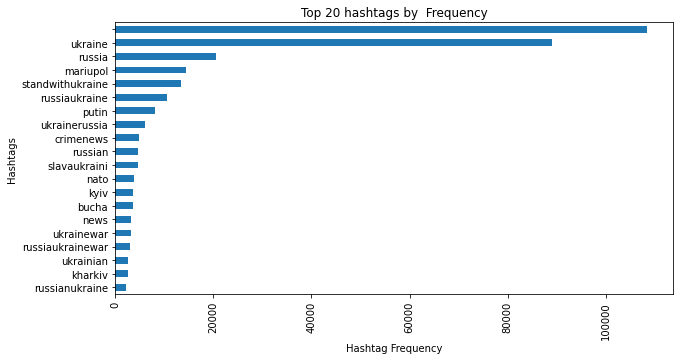

In [134]:
# Find the top 20 hashtags by frequency
plt.figure(figsize=(10,5))
joined_data_df["hashtags"].value_counts().sort_values(ascending=True)[-20:].plot.barh();
plt.title("Top 20 hashtags by  Frequency")
plt.xlabel("Hashtag Frequency")
plt.ylabel("Hashtags")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
plt.show()

In [135]:
joined_data_df["hashtags"].nunique()

136805

In [136]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
joined_data_df = joined_data_df.copy()
joined_data_df['hashtags'] = le.fit_transform(joined_data_df['hashtags'])
joined_data_df.head()

,following,followers,totaltweets,tweetcreatedts,hashtags,favorite_count,is_retweet,is_quote_status,weight,negative,text_length
0,1893.0,417389.0,335685.0,2022-02-26,108176,0.0,0,0,0.000533,0.222473,77.0
1,64.0,254.0,110.0,2022-02-26,97752,0.0,0,0,0.000533,0.078324,40.0
2,5766.0,5329.0,119448.0,2022-02-26,0,0.0,0,0,0.000533,0.147500,138.0
3,294.0,172.0,15270.0,2022-02-26,0,0.0,0,0,0.000533,0.883955,220.0
4,975.0,75.0,1988.0,2022-02-26,45096,0.0,0,0,0.000533,0.063437,16.0


In [137]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713008 entries, 0 to 713007
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   following        713008 non-null  float64       
 1   followers        713008 non-null  float64       
 2   totaltweets      713008 non-null  float64       
 3   tweetcreatedts   713008 non-null  datetime64[ns]
 4   hashtags         713008 non-null  int64         
 5   favorite_count   713008 non-null  float64       
 6   is_retweet       713008 non-null  int64         
 7   is_quote_status  713008 non-null  int64         
 8   weight           710366 non-null  float64       
 9   negative         713008 non-null  float64       
 10  text_length      712997 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 65.3 MB


In [138]:
# Convert datetime to float

# time_df["tweetcreatedts"] = pd.to_numeric(joined_data_df.index, downcast='float')

joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].astype(str)
joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].str.replace('-', '')
joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].astype(float)
print(joined_data_df["tweetcreatedts"])

0         20220226.0
1         20220226.0
2         20220226.0
3         20220226.0
4         20220226.0
             ...    
713003    20220226.0
713004    20220226.0
713005    20220226.0
713006    20220226.0
713007    20220226.0
Name: tweetcreatedts, Length: 713008, dtype: float64


In [139]:
#Check the null values
for column in joined_data_df.columns:
    print(f'Column {column} has {joined_data_df[column].isnull().sum()} null values')
joined_data_df.shape

Column following has 0 null values
Column followers has 0 null values
Column totaltweets has 0 null values
Column tweetcreatedts has 0 null values
Column hashtags has 0 null values
Column favorite_count has 0 null values
Column is_retweet has 0 null values
Column is_quote_status has 0 null values
Column weight has 2642 null values
Column negative has 0 null values
Column text_length has 11 null values


(713008, 11)

In [140]:
# Drop null values
joined_data_df = joined_data_df.dropna()
joined_data_df.shape

(710355, 11)

# Scale the data


In [141]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
scaler.fit(joined_data_df)

# Scale the data
scaled_data = scaler.transform(joined_data_df)

# Create a DataFrame with the scaled data
transformed_scaled_data = pd.DataFrame(scaled_data, columns=joined_data_df.columns)
transformed_scaled_data.head(5)

,following,followers,totaltweets,tweetcreatedts,hashtags,favorite_count,is_retweet,is_quote_status,weight,negative,text_length
0,-0.177340,0.689392,1.330729,-1.578197,1.019357,-0.038117,-0.645473,-0.222816,-0.78303,-0.542880,-0.925411
1,-0.298441,-0.101081,-0.678497,-1.578197,0.777848,-0.038117,-0.645473,-0.222816,-0.78303,-0.974009,-1.446835
2,0.079098,-0.091464,0.036029,-1.578197,-1.486933,-0.038117,-0.645473,-0.222816,-0.78303,-0.767114,-0.065765
3,-0.283213,-0.101236,-0.587728,-1.578197,-1.486933,-0.038117,-0.645473,-0.222816,-0.78303,1.435525,1.089825
4,-0.238122,-0.101420,-0.667253,-1.578197,-0.442120,-0.038117,-0.645473,-0.222816,-0.78303,-1.018536,-1.785056


In [142]:
df_corr = transformed_scaled_data.corr()['is_retweet'][2:-1]
top_features = df_corr.sort_values(ascending=False)
top_features

is_retweet         1.000000
tweetcreatedts     0.540694
weight             0.118537
is_quote_status    0.102020
negative           0.030368
hashtags           0.006460
totaltweets       -0.009477
favorite_count    -0.024603
Name: is_retweet, dtype: float64

Taking the numerical representation of the correlation, we see that the correlation is fairly low, with some of them being negative.

In [143]:
# Drop the data without correlation
transformed_scaled_data.drop("following", axis=1, inplace=True)
transformed_scaled_data.drop("followers", axis=1, inplace=True)
transformed_scaled_data.drop("text_length", axis=1, inplace=True)

transformed_scaled_data.head(5)

,totaltweets,tweetcreatedts,hashtags,favorite_count,is_retweet,is_quote_status,weight,negative
0,1.330729,-1.578197,1.019357,-0.038117,-0.645473,-0.222816,-0.78303,-0.542880
1,-0.678497,-1.578197,0.777848,-0.038117,-0.645473,-0.222816,-0.78303,-0.974009
2,0.036029,-1.578197,-1.486933,-0.038117,-0.645473,-0.222816,-0.78303,-0.767114
3,-0.587728,-1.578197,-1.486933,-0.038117,-0.645473,-0.222816,-0.78303,1.435525
4,-0.667253,-1.578197,-0.442120,-0.038117,-0.645473,-0.222816,-0.78303,-1.018536


# Create a base LGBM Classifier model - gradient boosting framework LightGBM

LightGBM grows tree vertically while other tree based learning algorithms grow trees horizontally. 
It means that LightGBM grows tree leaf-wise while other algorithms grow level-wise. It will choose 
the leaf with max delta loss to grow. When growing the same leaf, leaf-wise algorithm can reduce more 
loss than a level-wise algorithm.

In [144]:
!pip install lightgbm
import lightgbm as lgb
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [146]:
from sklearn import preprocessing
from sklearn import utils

# Declare feature vector and target variable
X = transformed_scaled_data.drop(['is_retweet'], 1)
y = transformed_scaled_data['is_retweet']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [147]:
# Check data types
transformed_scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710355 entries, 0 to 710354
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   totaltweets      710355 non-null  float64
 1   tweetcreatedts   710355 non-null  float64
 2   hashtags         710355 non-null  float64
 3   favorite_count   710355 non-null  float64
 4   is_retweet       710355 non-null  float64
 5   is_quote_status  710355 non-null  float64
 6   weight           710355 non-null  float64
 7   negative         710355 non-null  float64
dtypes: float64(8)
memory usage: 43.4 MB


In [148]:
#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y = lab.fit_transform(y)

#view transformed values
print(y)


[0 0 0 ... 0 0 0]


In [149]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print('Training set shape ', X_train.shape)
print('Training set shape ', y_train.shape)
print('Test set shape ', X_test.shape)
print('Test set shape ', y_test.shape)

Training set shape  (497248, 7)
Training set shape  (497248,)
Test set shape  (213107, 7)
Test set shape  (213107,)


In [150]:
# Create scaler instance
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [151]:
# predict the results
y_pred=clf.predict(X_test)

In [152]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9377


# Compare train and test set accuracy

In [153]:
y_pred_train = clf.predict(X_train)

In [154]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9389


In [155]:
#Check for overfitting

# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9389
Test set score: 0.9377


In [156]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[139567  10676]
 [  2598  60266]]

True Positives(TP) =  139567

True Negatives(TN) =  60266

False Positives(FP) =  10676

False Negatives(FN) =  2598


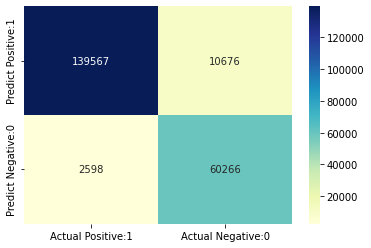

In [157]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [158]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    150243
           1       0.85      0.96      0.90     62864

    accuracy                           0.94    213107
   macro avg       0.92      0.94      0.93    213107
weighted avg       0.94      0.94      0.94    213107

